# Data Mining Project

## Knowledge Extraction Pipeline

This notebooks defines a series of steps that end up in the production of the desired prediction, including Data Preparation, Modeling and Evaluation, according to CRISP-DM guidelines.
For information regarding Data Understanding, please refer to [Data Understanding](data_understanding.ipynb).


#### Dependencies

The code block below defines the major dependencies for the project.
To make sure you are set up, please run the following command in order to update dependencies:

```bash
pip install -r requirements.txt
```

We chose to use a set of technologies that we were familiar with and should be adequate for the problem at hand.
These include **sklearn** to model the data, **matplotlib** and **seaborn** to create graphics and **pandas** to better read the data.


In [79]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import os

from utils.files import *

## Data Understanding

### Related Work

Sports related predictions are a fairly common problem.
It serves of value for different entities, such as bookmakers, sports teams and fans.
This fact together with the recent increase in the availability of data justifies the employment of machine learning techniques to the problem. [<a href="#ref1">1</a>]

The problem of predicting the outcome of a basketball game has been approached in different ways.
A common take on the subject is to try and predict the outcome of a single game, as opposed to the set of qualified teams.
Nevertheless, some similarities found between solutions were the use of machine learning algorithms and of similar attributes (rebounds, free throws, turn overs, etc).

In [<a href="#ref2">2</a>] the authors identify the characteristic high-dimensionality of the problem, and employ a Support Vector Machine Algorithm that predicted the outcome of a game with 88% accuracy.

Among common attributes, the author of [<a href="#ref3">3</a>] found that the most important ones were Free Throws, Offensive Rebounds, Turn Overs and +/- (Plus Minus).
They were also able to predict the champion team with an 86% recall using Random Forest.

Finally, the authors of [<a href="#ref4">4</a>] used a Naive Bayes Classifier to predict the outcome of games with 67% accuracy.


## Data Preparation

TODO: add text about data set (summary from data exploration)


TODO: add text about which transformations were made


In [80]:
df = pd.read_csv(os.path.join(DATA_PATH, DATA_MERGED))
df.head()

,year,playoff,confID,per,eff,awardCount,teamChange,coachWLRatio
0,9,0,EA,13.166803,0.295042,0.0,0.453509,1.351403
1,10,1,EA,11.398591,0.331618,0.0,0.642857,0.133333
2,1,0,EA,13.166803,0.295042,0.0,0.453509,1.351403
3,2,1,EA,12.237540,0.306456,0.0,0.615385,0.391304
4,3,1,EA,17.755260,0.312389,0.0,0.166667,1.222222


## Modeling and Evaluation

The following block imports general utility functions (defined in `utils/modeling.py`) that will serve to model the data and access results.

We chose to create the training and testing subsets in a temporal fashion.
The reason being it wouldn't make sense to scatter data from different years, since our game data is chronological.
As an example, we can train the model with the first 9 years and use the 10th and last to test the model's predictions.


In [81]:
from utils.modeling import *


### Ranking-based prediction

{'EA': 0.3597065120349039, 'WE': 0.3759513831775252}


,year,confID,per,eff,awardCount,teamChange,coachWLRatio,playoff,pred,Correct
1,10,EA,11.398591,0.331618,0.0,0.642857,0.133333,1,0,False
13,10,EA,18.168412,0.352116,0.0,0.461538,0.545455,0,0,True
24,10,EA,18.569396,0.380633,1.0,0.384615,1.466667,0,1,False
35,10,EA,16.745198,0.359707,1.0,0.526316,2.071429,1,1,True
36,10,EA,16.745198,0.359707,1.0,0.526316,1.351403,1,1,True
55,10,EA,14.562877,0.330955,1.0,0.600000,0.947368,1,0,False
68,10,WE,18.152116,0.321577,3.0,0.666667,1.352941,1,0,False
83,10,WE,18.847406,0.395711,1.0,0.733333,1.351403,0,1,False
94,10,EA,17.798069,0.361471,0.0,0.307692,1.222222,0,1,False
95,10,EA,17.798069,0.361471,0.0,0.307692,1.351403,0,1,False


Accuracy: 50.0%
Precision: 55.56%
Recall: 55.56%
F1-measure: 55.56%


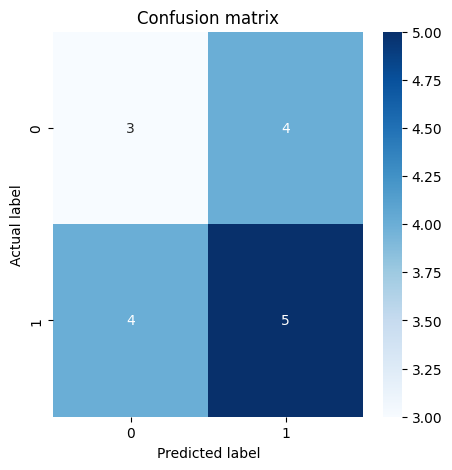

In [82]:
def pred():
    # check if df has keys confID per, eff. if not, return
    if not {'confID', 'per', 'eff'}.issubset(df.columns):
        return
    
    test_year = 10
    test_df = df[df['year'] == test_year]

    X_test = test_df.drop(columns=['playoff'])
    y_test = test_df['playoff']

    criteria = 'eff'
    threshold = { 
        'EA' : X_test[X_test['confID'] == 'EA'][criteria].nlargest(4).min(),
        'WE' : X_test[X_test['confID'] == 'WE'][criteria].nlargest(4).min()
        }
    y_pred = X_test.apply(lambda row: 1 if row[criteria] >= threshold[row['confID']] else 0, axis=1)
    X_test['playoff'] = y_test
    X_test['pred'] = y_pred
    X_test['Correct'] = X_test.apply(lambda row: True if row['pred'] == row['playoff'] else False, axis=1)

    print(threshold)
    display(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    displayResults(Result(y_test, y_pred, accuracy, precision, recall, f1))

pred()


### Modeling

In [83]:
from utils.modeling import *

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm

models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6, min_samples_leaf=8, min_samples_split=3),
    "Random Forest" : RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42),
    "Naive Bayes" : GaussianNB(),
    "Neural Net" : MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42, max_iter=500),
    "SVM" : svm.SVC(kernel='linear', C=1, random_state=42)
    }

# very best hyperparametrs

models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6, min_samples_leaf=8, min_samples_split=3),
    "Random Forest" : RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42),
    "Naive Bayes" : GaussianNB(),
    "Neural Net" : MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42, max_iter=500),
    "SVM" : svm.SVC(kernel='linear', C=1, random_state=42)
    }

def testDf(test_year, models, display_results=True):
    print("Testing on year", test_year)
    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    for name, model in models.items():
        res = runModel(df, model, test_year=test_year)
        results.loc[len(results)] = [name] + res.toRow()
    
    #make an average row
    results.loc[len(results)] = ["Average"] + results.mean(axis=0, numeric_only=True).tolist()

    if display_results: display(results)
    return results

avg_score = pd.DataFrame(columns=['year', 'Accuracy', 'Precision', 'Recall', 'F1'])

for i in range(4, 11):
    r = testDf(i, models, display_results=True)
    avg_score.loc[len(avg_score)] = [str(i)] +(r.iloc[-1]).tolist()[1:]

avg_score.loc[len(avg_score)] = ["Average"] + avg_score.mean(axis=0, numeric_only=True).tolist()
display(avg_score)

Testing on year 4


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.5000,0.538462,0.777778,0.636364
1,Random Forest,0.4375,0.500000,0.444444,0.470588
2,Naive Bayes,0.5625,0.625000,0.555556,0.588235
3,Neural Net,0.4375,0.500000,0.444444,0.470588
4,SVM,0.5000,0.666667,0.222222,0.333333
5,Average,0.4875,0.566026,0.488889,0.499822


Testing on year 5


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.470588,0.583333,0.636364,0.608696
1,Random Forest,0.764706,0.888889,0.727273,0.800000
2,Naive Bayes,0.588235,0.750000,0.545455,0.631579
3,Neural Net,0.352941,0.500000,0.363636,0.421053
4,SVM,0.470588,1.000000,0.181818,0.307692
5,Average,0.529412,0.744444,0.490909,0.553804


Testing on year 6


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.600000,0.666667,0.666667,0.666667
1,Random Forest,0.800000,0.875000,0.777778,0.823529
2,Naive Bayes,0.800000,0.875000,0.777778,0.823529
3,Neural Net,0.666667,0.750000,0.666667,0.705882
4,SVM,0.666667,0.642857,1.000000,0.782609
5,Average,0.706667,0.761905,0.777778,0.760443


Testing on year 7


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.866667,0.875000,0.875,0.875
1,Random Forest,0.733333,0.750000,0.750,0.750
2,Naive Bayes,0.600000,0.625000,0.625,0.625
3,Neural Net,0.866667,0.875000,0.875,0.875
4,SVM,0.800000,0.857143,0.750,0.800
5,Average,0.773333,0.796429,0.775,0.785


Testing on year 8


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.571429,0.625000,0.625,0.625
1,Random Forest,0.571429,0.625000,0.625,0.625
2,Naive Bayes,0.428571,0.500000,0.500,0.500
3,Neural Net,0.571429,0.625000,0.625,0.625
4,SVM,0.571429,0.583333,0.875,0.700
5,Average,0.542857,0.591667,0.650,0.615


Testing on year 9


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.466667,0.500000,0.625,0.555556
1,Random Forest,0.866667,0.875000,0.875,0.875000
2,Naive Bayes,0.733333,0.750000,0.750,0.750000
3,Neural Net,0.866667,0.875000,0.875,0.875000
4,SVM,0.800000,0.777778,0.875,0.823529
5,Average,0.746667,0.755556,0.800,0.775817


Testing on year 10


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.3750,0.444444,0.444444,0.444444
1,Random Forest,0.4375,0.500000,0.444444,0.470588
2,Naive Bayes,0.5625,0.625000,0.555556,0.588235
3,Neural Net,0.4375,0.500000,0.444444,0.470588
4,SVM,0.5000,0.545455,0.666667,0.600000
5,Average,0.4625,0.522980,0.511111,0.514771


,year,Accuracy,Precision,Recall,F1
0,4,0.487500,0.566026,0.488889,0.499822
1,5,0.529412,0.744444,0.490909,0.553804
2,6,0.706667,0.761905,0.777778,0.760443
3,7,0.773333,0.796429,0.775000,0.785000
4,8,0.542857,0.591667,0.650000,0.615000
5,9,0.746667,0.755556,0.800000,0.775817
6,10,0.462500,0.522980,0.511111,0.514771
7,Average,0.606991,0.677001,0.641955,0.643522


In [85]:
from sklearn import ensemble as ens

models_dict = {}

# Voting with all models
# models_dict['ensemble hard'] = ens.VotingClassifier(estimators=list(models.items()), voting='hard')

# Voting just for Decision Tree and Random Forest
models_new={
    "Decision Tree" : DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6, min_samples_leaf=8, min_samples_split=3),
    "Random Forest" : RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
} 
models_dict['ensemble hard'] = ens.VotingClassifier(estimators=list(models_new.items()), voting='hard')

ensemble_score = pd.DataFrame(columns=['year', 'Accuracy', 'Precision', 'Recall', 'F1'])

for i in range(4, 11):
    r = testDf(i,models_dict,display_results=True)
    ensemble_score.loc[len(ensemble_score)] = [str(i)] + (r.iloc[-1]).tolist()[1:]

ensemble_score.loc[len(ensemble_score)] = ["Average"] + ensemble_score.mean(axis=0, numeric_only=True).tolist()
display(ensemble_score)

Testing on year 4


,Model,Accuracy,Precision,Recall,F1
0,ensemble hard,0.5,0.666667,0.222222,0.333333
1,Average,0.5,0.666667,0.222222,0.333333


Testing on year 5


,Model,Accuracy,Precision,Recall,F1
0,ensemble hard,0.588235,0.75,0.545455,0.631579
1,Average,0.588235,0.75,0.545455,0.631579


Testing on year 6


,Model,Accuracy,Precision,Recall,F1
0,ensemble hard,0.733333,0.857143,0.666667,0.75
1,Average,0.733333,0.857143,0.666667,0.75


Testing on year 7


,Model,Accuracy,Precision,Recall,F1
0,ensemble hard,0.533333,0.666667,0.25,0.363636
1,Average,0.533333,0.666667,0.25,0.363636


Testing on year 8


,Model,Accuracy,Precision,Recall,F1
0,ensemble hard,0.571429,0.583333,0.875,0.7
1,Average,0.571429,0.583333,0.875,0.7


Testing on year 9


,Model,Accuracy,Precision,Recall,F1
0,ensemble hard,0.6,0.583333,0.875,0.7
1,Average,0.6,0.583333,0.875,0.7


Testing on year 10


,Model,Accuracy,Precision,Recall,F1
0,ensemble hard,0.375,0.444444,0.444444,0.444444
1,Average,0.375,0.444444,0.444444,0.444444


,year,Accuracy,Precision,Recall,F1
0,4,0.500000,0.666667,0.222222,0.333333
1,5,0.588235,0.750000,0.545455,0.631579
2,6,0.733333,0.857143,0.666667,0.750000
3,7,0.533333,0.666667,0.250000,0.363636
4,8,0.571429,0.583333,0.875000,0.700000
5,9,0.600000,0.583333,0.875000,0.700000
6,10,0.375000,0.444444,0.444444,0.444444
7,Average,0.557333,0.650227,0.554113,0.560428


In [86]:
DecisionTree_grid = DecisionTree_GridSearch(df)

# {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4}


{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9}


In [87]:
RandomForest_grid = RandomForest_GridSearch(df)

# {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_split': 9, 'n_estimators': 10}


{'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_split': 3, 'n_estimators': 10}


In [88]:
NeuralNet_grid = NeuralNet_GridSearch(df)

# {'activation': 'tanh', 'alpha': 1e-06, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 5000, 'solver': 'sgd'}


/home/luis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
SVM_grid = SVM_GridSearch(df)


# {'C': 0.6000000000000001, 'kernel': 'rbf', 'probability': False, 'shrinking': False}


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'C': 0.6000000000000001, 'kernel': 'rbf', 'probability': False, 'shrinking': False}


In [ ]:
# For year=10
improved_models = {
    "Decision Tree" : DecisionTreeClassifier(**DecisionTree_grid,random_state=42),
    "Random Forest" : RandomForestClassifier(**RandomForest_grid,random_state=42),
    "Naive Bayes" : GaussianNB(),
    "Neural Net" : MLPClassifier(**NeuralNet_grid,random_state=42),
    "SVM" : svm.SVC(**SVM_grid,random_state=42)
    }

testDf(10,improved_models)

Testing on year 10


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.5625,0.625,0.555556,0.588235
1,Random Forest,0.4375,0.500,0.444444,0.470588
2,Naive Bayes,0.5625,0.625,0.555556,0.588235
3,Neural Net,0.3125,0.375,0.333333,0.352941
4,SVM,0.4375,0.500,0.777778,0.608696
5,Average,0.4625,0.525,0.533333,0.521739


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.5625,0.625,0.555556,0.588235
1,Random Forest,0.4375,0.500,0.444444,0.470588
2,Naive Bayes,0.5625,0.625,0.555556,0.588235
3,Neural Net,0.3125,0.375,0.333333,0.352941
4,SVM,0.4375,0.500,0.777778,0.608696
5,Average,0.4625,0.525,0.533333,0.521739


### References

<a id="ref1"></a> [1] Bunker, R. P., & Thabtah, F. (2019). A machine learning framework for sport result prediction. Applied Computing and Informatics, 15(1), 27-33. https://doi.org/10.1016/j.aci.2017.09.005

<a id="ref2"></a> [2] Jadhav, A. (2016). Predicting the NBA playoff using SVM. CORE. https://core.ac.uk/display/230494997?utm_source=pdf&utm_medium=banner&utm_campaign=pdf-decoration-v1

<a id="ref3"></a> [3] Jien, O. W. (2022, January 5). Prediction model for NBA championship by Machine Learning. Medium. https://medium.com/@weinjien99/prediction-model-for-nba-championship-by-machine-learning-8e8884ea72c8

<a id="ref4"></a> [4] D. Miljković, L. Gajić, A. Kovačević and Z. Konjović, "The use of data mining for basketball matches outcomes prediction," IEEE 8th International Symposium on Intelligent Systems and Informatics, Subotica, Serbia, 2010, pp. 309-312, doi: 10.1109/SISY.2010.5647440.
